## Temporal Autocorrelation

CBIBS Buoy data download example (Goose's Reef, GR):
```
http://buoybay.noaa.gov/sites/default/files/data-reports/process-reports.php?station%5B%5D=GR&year%5B%5D=2007&year%5B%5D=2008&year%5B%5D=2009&year%5B%5D=2010&year%5B%5D=2011&year%5B%5D=2012&year%5B%5D=2013&year%5B%5D=2014&year%5B%5D=2015&year%5B%5D=2016&year%5B%5D=2017&year%5B%5D=2018&year%5B%5D=2019&year%5B%5D=2020&year%5B%5D=2021&year%5B%5D=2022&year%5B%5D=2023&year%5B%5D=2024&type%5B%5D=ocean&
```

- Website: https://buoybay.noaa.gov/data/data-download
- [Meaning of QC flags](https://buoybay.noaa.gov/sites/default/files/2023-02/CBIBSQCCodeMeanings_2.pdf) for CBIBS data

In [2]:
import os

import pandas as pd
import xarray as xr
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
REPO_ROOT = '/Users/rwegener/repos/chesapeake_mhw'

### Reading and cleaning data

* GR = Goose's Reef (3532 days of data ~10 years from Apr 2011-Mar 2024)
* SR = Stingray Point (3107 days of data ~8.5 years from Jun 2012-Mar 2024)
* AN = Annapolis (2308 days of data ~6 years from Sept 2013-Mar 2024)

Also tried:
* SN = Patapsco (not enough data, only 640 days ~2 years)
* YS = York Split (not enough data)

In [5]:
buoy_filepath = os.path.join(REPO_ROOT, 'data/01_raw', 'GR_OCEAN_2007-2024.csv')
# buoy_filepath = os.path.join(REPO_ROOT, 'data/raw', 'SR_OCEAN_2007-2024.csv')
# buoy_filepath = os.path.join(REPO_ROOT, 'data/raw', 'AN_OCEAN_2007-2024.csv')

In [6]:
buoy = pd.read_csv(
    buoy_filepath, 
    usecols=['Time (UTC)', 'Temperature QC', 'Temperature'],
)

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_3847/704043643.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  buoy = pd.read_csv(


In [7]:
# Remove unit rows
buoy = buoy.drop([0, 1])
# Remove any data that is bad, questionable, or missing
buoy = buoy[buoy['Temperature QC'].isin([1, 2])]

In [8]:
buoy['datetime'] = pd.to_datetime(buoy['Time (UTC)'])

In [9]:
# Make datetime timezone aware
buoy.datetime = buoy.datetime.dt.tz_localize('UTC')
# Convert to eastern time
buoy.datetime = buoy.datetime.dt.tz_convert('America/New_York')

In [10]:
# An additional QC since some measurements with QC flag of 2 have very high values
buoy.loc[buoy.Temperature > 40] = None

Subset to nighttime and take mean for daily value (Time is UTC)

In [11]:
# filter to just obserations between midnight and 7am local time
buoy_night = buoy[buoy.datetime.dt.hour.isin(range(0, 7))] 

<Axes: xlabel='datetime', ylabel='Temperature'>

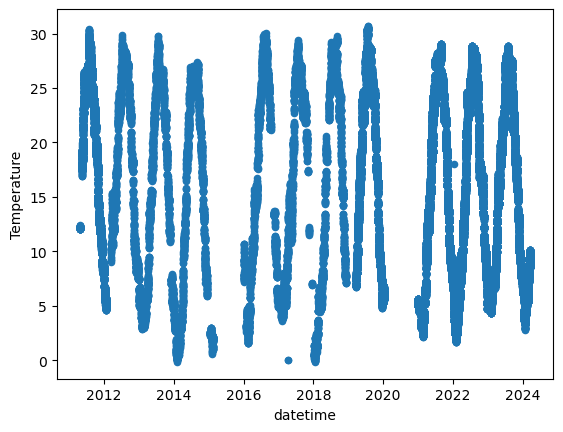

In [12]:
buoy_night.plot.scatter('datetime', 'Temperature')

In [13]:
# take average for each day
buoy_daily = buoy_night.groupby(buoy_night.datetime.dt.date).Temperature.mean()


In [14]:
buoy_daily.index = pd.to_datetime(buoy_daily.index)

In [14]:
# resample to ensure daily observations
# buoy_daily.index = pd.to_datetime(buoy_daily.index)
# buoy_daily = buoy_daily.resample('D').ffill() 

In [15]:
daily = pd.date_range(buoy_daily.index[0], buoy_daily.index[-1], freq='D')
buoy_daily = buoy_daily.reindex(daily, fill_value=np.NaN)

In [16]:
buoy_daily.index.name = 'datetime'

## Co-locate satellite data with buoy data

In [21]:
geopolar_path = os.path.join(
    REPO_ROOT,
    'data/01_raw',
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20231231.nc'
)

In [22]:
geopolar = xr.open_dataset(
    geopolar_path, 
    drop_variables=['analysis_error', 'sea_ice_fraction', 'mask']
)

In [23]:
geopolar = geopolar - 273

In [24]:
# Goose Reef lat/lon
lat_gr = 38.556
lon_gr = -76.415

In [25]:
# Stingray Point lat/lon
# lat_gr = 37.567
# lon_gr = -76.262

In [26]:
# Annapolis lat/lon
# lat_gr = 38.964
# lon_gr = -76.447

In [27]:
geopolar_gr = geopolar.sel(lat=lat_gr, lon=lon_gr, method='nearest')

In [28]:
# convert to dataframe
geopolar_df = geopolar_gr.to_dataframe()
# clean
geopolar_df = geopolar_df.drop(['lat', 'lon'], axis=1)
geopolar_df = geopolar_df.reset_index()

In [29]:
# create a date column
geopolar_df['date'] = pd.to_datetime(geopolar_df.time.dt.date)

Merge the geopolar dataframe with the buoy data to create a new dataframe with all the data in the same dataframe

In [31]:
observed_temps = geopolar_df.merge(buoy_daily, how='inner', left_on='date', right_on='datetime')

In [32]:
# cleaning
# rename columns
observed_temps = observed_temps.rename(
    {'analysed_sst': 'geopolar_sst',
     'Temperature': 'goosereef_sst',
    },
    axis=1,
)
# drop un-needed columns
observed_temps = observed_temps.drop('time', axis=1)
# set date as index and convert to datetime
observed_temps = observed_temps.set_index(pd.to_datetime(observed_temps.date))
# remove the one duplicate row
observed_temps = observed_temps[~observed_temps.index.duplicated()]
# resample to ensure daily observations
observed_temps = observed_temps.resample('D').ffill() 
# drop un-needed columns
observed_temps = observed_temps.drop('date', axis=1)

<Axes: xlabel='date'>

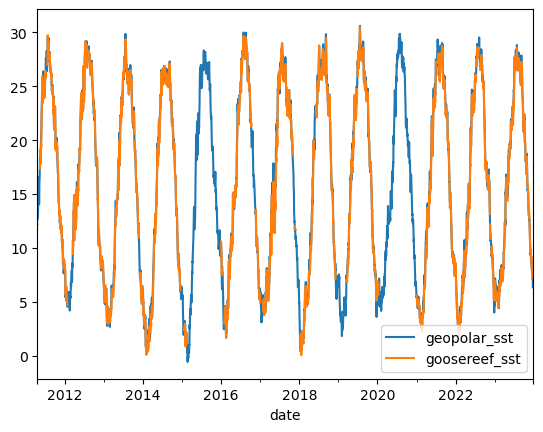

In [33]:
observed_temps[['geopolar_sst', 'goosereef_sst']].plot()

###  Buoy-based SST anomaly calculation

### Remove Climatology

In [34]:
observed_temps['month'] = observed_temps.index.month
observed_temps['day'] = observed_temps.index.day

In [35]:
clim_geo = observed_temps.geopolar_sst.groupby([observed_temps.month, observed_temps.day]).mean()


In [36]:
clim_geo = clim_geo.reset_index()

In [37]:
clim_geo = clim_geo.rename({'geopolar_sst': 'geopolar_clim'}, axis=1)

Goose Reef

In [40]:
clim_goose = observed_temps.goosereef_sst.groupby([observed_temps.month, observed_temps.day]).mean()


In [41]:
clim_goose = clim_goose.reset_index()

In [42]:
clim_goose = clim_goose.rename({'goosereef_sst': 'goosereef_clim'}, axis=1)

In [43]:
observed_temps['year'] = observed_temps.index.year

Merge anomaly and climatology into observed_temps

In [45]:
observed_temps = observed_temps.merge(clim_geo, how='left', on=['month', 'day'])

In [46]:
observed_temps['geopolar_anom'] = observed_temps.geopolar_sst - observed_temps.geopolar_clim

In [47]:
observed_temps

,spatial_ref,geopolar_sst,goosereef_sst,month,day,year,geopolar_clim,geopolar_anom
0,-273,12.639984,12.181429,4,18,2011,13.096145,-0.456161
1,-273,12.679993,12.183590,4,19,2011,13.217684,-0.537691
2,-273,12.910004,NaN,4,20,2011,13.418452,-0.508449
3,-273,12.979980,NaN,4,21,2011,13.669990,-0.690009
4,-273,12.880005,NaN,4,22,2011,13.839996,-0.959991
...,...,...,...,...,...,...,...,...
4636,-273,6.729980,7.601857,12,27,2023,6.583839,0.146142
4637,-273,7.549988,7.460857,12,28,2023,6.718457,0.831531
4638,-273,7.790009,7.499429,12,29,2023,6.658457,1.131552
4639,-273,7.779999,7.635286,12,30,2023,6.553840,1.226159


Next Merge

In [48]:
observed_temps = observed_temps.merge(clim_goose, how='left', on=['month', 'day'])

In [49]:
observed_temps['goosereef_anom'] = observed_temps.goosereef_sst - observed_temps.goosereef_clim


In [50]:
observed_temps['date'] = pd.to_datetime(observed_temps[['year', 'month', 'day']])

In [51]:
observed_temps = observed_temps.set_index('date')

Text(0, 0.5, 'SST Anomaly from Climatology (degrees C)')

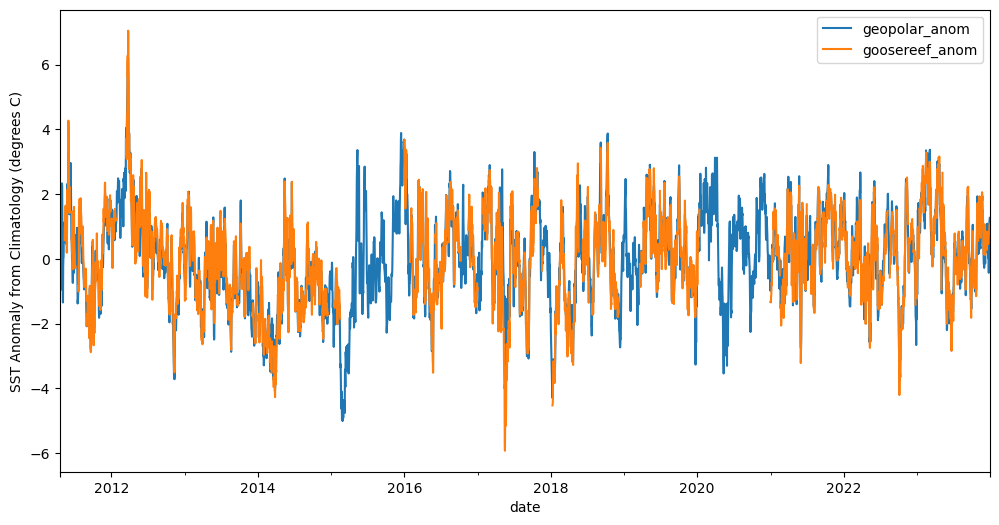

In [52]:
observed_temps[['geopolar_anom', 'goosereef_anom']].plot(figsize=(12, 6))

plt.ylabel('SST Anomaly from Climatology (degrees C)')


## Calculate anomaly

In [55]:
observed_temps['anom_error'] = observed_temps.geopolar_anom - observed_temps.goosereef_anom

Text(0, 0.5, 'geopolar_anom - goosereef_anom (degrees C)')

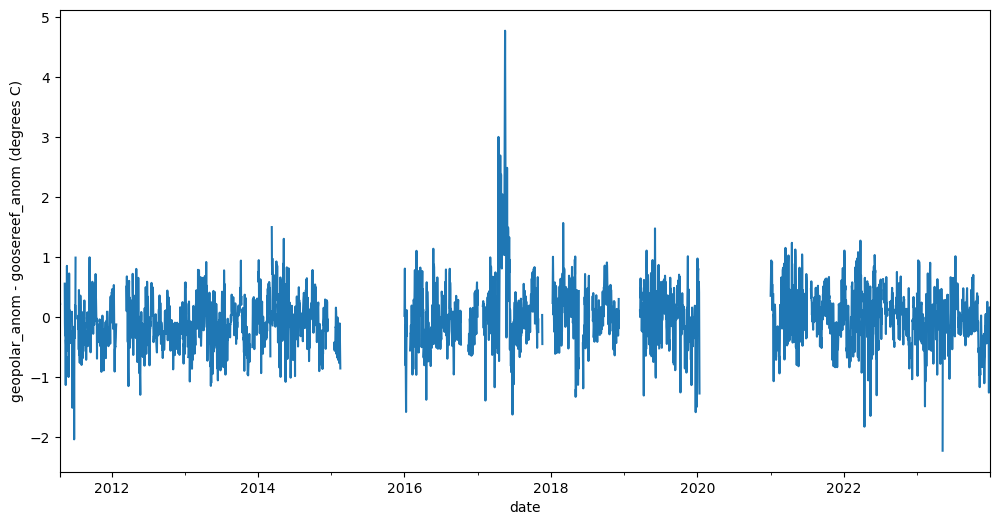

In [56]:
observed_temps.anom_error.plot(figsize=(12, 6))

plt.ylabel('geopolar_anom - goosereef_anom (degrees C)')

## Temporal Autocorrelation calculation

[https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html)

In [58]:
# nans are dropped in computation 
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html
acf = sm.tsa.acf(observed_temps.anom_error, missing='drop')  # , nlags=400)

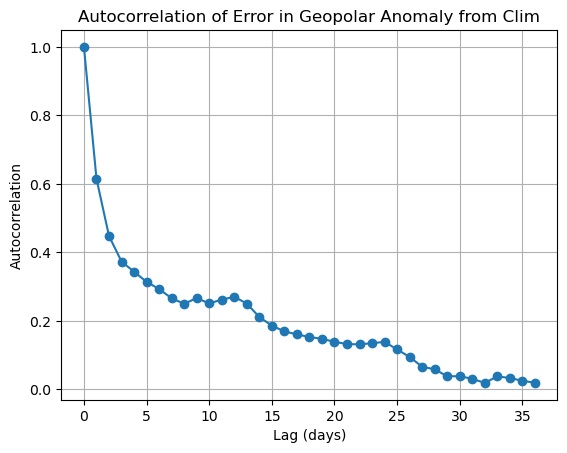

In [59]:
plt.plot(acf, marker='o')
plt.title('Autocorrelation of Error in Geopolar Anomaly from Clim')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')

plt.grid()

### Decorrelation Timescale

In [60]:
1/np.e

0.36787944117144233

In [61]:
for index, value in enumerate(acf):
    if value < 1/np.e:
        print('First index below 1/e is:', index)
        break

First index below 1/e is: 4
